In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from game_of_life import next_frame, random_state

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['animation.html'] = 'html5'
plt.style.use('classic')

%matplotlib inline

tf.__version__

'1.13.1'

In [3]:
class Input:
    W, H = 10, 10

    def generator(self):
        state = random_state(self.W, self.H)
        SEQ_LEN = 150
        current_seq_idx = 0

        while True:
            current_seq_idx += 1
            if current_seq_idx > SEQ_LEN:
                current_seq_idx = 0
                state = random_state(self.W, self.H)

            inp = np.expand_dims(state, -1)
            out = np.expand_dims(next_frame(state), -1)

            yield inp, out

    def as_dataset(self, batch_size):
        shapes =(tf.TensorShape([self.W, self.H, 1]), tf.TensorShape([self.W, self.H, 1]))
        dataset = tf.data.Dataset.from_generator(
            self.generator,
            (tf.int32,) * 2,
            shapes
        )

        dataset = dataset.shuffle(1024).batch(batch_size).repeat()

        return dataset

In [177]:
def mk_model():
    inp = tf.keras.layers.Input(shape=(None, None, 1))
    x = inp
    x = tf.keras.layers.Conv2D(50, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(4, kernel_size=1, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(40, kernel_size=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(2, kernel_size=1, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(50, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(x)
    model = tf.keras.Model(inp, x)
    
    model.compile(  
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model


model = mk_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 50)    500       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 4)     204       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 40)    680       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 2)     82        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 50)    950       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 1)     51        
Total para

In [179]:
model.save('conway_random.h5')

In [180]:
model.fit(
    Input().as_dataset(512), steps_per_epoch=100,
    epochs=2
)

Epoch 1/2
100/100 [==============================] - 86s 865ms/step - loss: 311.5184 - acc: 0.6674
Epoch 2/2
100/100 [==============================] - 64s 639ms/step - loss: 256.4006 - acc: 0.7114


In [181]:
model.save(f'conway_2_epochs.h5')

In [182]:
model.fit(
    Input().as_dataset(512), steps_per_epoch=100,
    epochs=1
)

100/100 [==============================] - 65s 647ms/step - loss: 132.5731 - acc: 0.8912


In [183]:
model.save(f'conway_3_epochs.h5')

In [184]:
model.fit(
    Input().as_dataset(512), steps_per_epoch=100,
    epochs=1
)

100/100 [==============================] - 68s 677ms/step - loss: 46.6996 - acc: 0.9731


In [185]:
model.save(f'conway_4_epochs.h5')

In [189]:
model.fit(
    Input().as_dataset(512), steps_per_epoch=100,
    epochs=4
)

100/100 [==============================] - 41s 414ms/step - loss: 19.4583 - acc: 0.9883


In [193]:
model.save(f'conway_8_epochs.h5')

In [5]:
def next_learned_frame(model, state):
    state = np.expand_dims(state, 0)
    state = np.expand_dims(state, -1)
    return np.squeeze(model.predict(state))

In [6]:
def compare_label_with_pred(out, pred):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.tight_layout(pad=1.0)

    axs[0, 0].set_title('label')
    axs[0, 0].imshow(out)

    axs[0, 1].set_title('prediction')
    axs[0, 1].imshow(pred)

    axs[1, 0].set_title('difference')
    axs[1, 0].imshow(pred - out)

    axs[1, 1].set_title('threshold diff')
    axs[1, 1].imshow((pred > 0.5) - out)
    
    return axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b5ef74b38>,
      dtype=object)

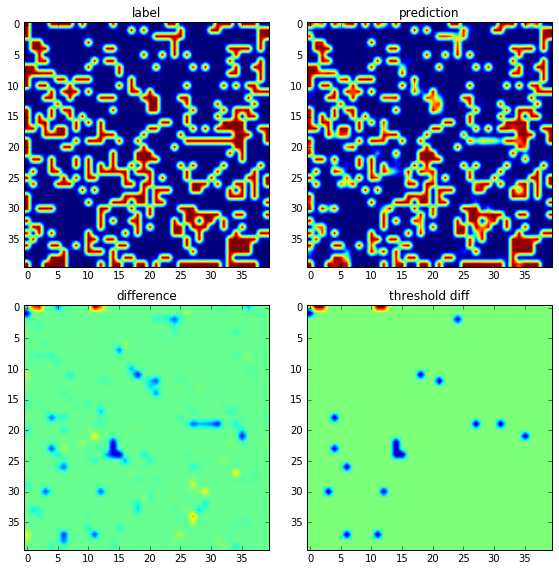

In [7]:
inp = random_state(40, 40)
out = next_frame(inp)
pred = next_learned_frame(model, inp)

compare_label_with_pred(out, pred)

In [4]:
model_random = tf.keras.models.load_model(f'conway_random.h5')
model_2_epochs = tf.keras.models.load_model(f'conway_2_epochs.h5')
model_3_epochs = tf.keras.models.load_model(f'conway_3_epochs.h5')
model_4_epochs = tf.keras.models.load_model(f'conway_4_epochs.h5')
model_8_epochs = tf.keras.models.load_model(f'conway_8_epochs.h5')
model_perfect = tf.keras.models.load_model(f'conway_perfect_2.5k.h5')
model = model_8_epochs

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


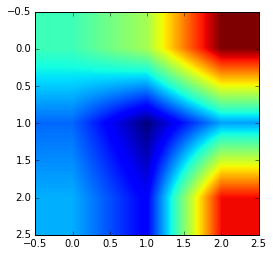

In [8]:
plt.imshow(np.squeeze(model_8_epochs.layers[1].get_weights()[0])[:,:,5])

In [13]:
class AnimateConway:
    def __init__(self, state, next_frame):
        fig, ax = plt.subplots()
        plt.close()
        self.ax = ax
        self.fig = fig
        self.state = state
        self.next_frame = next_frame
    
    def loop(self, i):
        self.state = self.next_frame(self.state > 0.5)
        return (self.ax.imshow(self.state),)
    
    def animate(self, frames):
        return animation.FuncAnimation(
            self.fig,
            self.loop,
            frames=frames,
            interval=50
        )

In [210]:
AnimateConway(inp, lambda x: next_learned_frame(model_random, x)).animate(frames=100)

In [16]:
AnimateConway(inp, lambda x: next_learned_frame(model_4_epochs, x)).animate(frames=100)

In [12]:
from matplotlib import 

In [19]:
class AnimateConwayComparison:
    def __init__(self, state, next_frame, next_learned): 
        fig, axs = plt.subplots(2, 2, figsize=(5, 5))
        fig.tight_layout(pad=1.0)
        self.axs = axs
        self.fig = fig

        self.label_state = state
        self.predicted_state = state

        self.next_frame = next_frame
        self.next_learned = next_learned

        plt.close()
        
    def plot_comparison(self):
        out, pred = self.label_state, self.predicted_state

        self.axs[0, 0].set_title('label')
        self.axs[0, 0].imshow(out)

        self.axs[0, 1].set_title('prediction')
        self.axs[0, 1].imshow(pred)

        self.axs[1, 0].set_title('difference')
        self.axs[1, 0].imshow(pred - out)

        self.axs[1, 1].set_title('threshold diff')
        self.axs[1, 1].imshow((pred > 0.5) - out)

        return self.axs
    
    def loop(self, i):
        self.label_state = self.next_frame(self.label_state)
        self.predicted_state = self.next_learned(self.predicted_state)

        return (self.plot_comparison(),)
    
    def animate(self, frames):
        return matplotlib.animation.FuncAnimation(
            self.fig,
            self.loop,
            frames=frames,
            interval=50
        )

In [ ]:
AnimateConwayComparison(
    inp,
    next_frame,
    lambda x: next_learned_frame(model_3_epochs, x)
).animate(100)

In [ ]:
AnimateConwayComparison(
    inp,
    next_frame,
    lambda x: next_learned_frame(model_8_epochs, x)
).animate(100)

In [ ]:
AnimateConwayComparison(
    inp,
    next_frame,
    lambda x: next_learned_frame(model_perfect, x)
).animate(50)